In [1]:
import datetime
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["font.size"] = 16

from qiskit import QuantumCircuit, IBMQ, schedule
import qiskit.pulse as pulse
from qiskit.quantum_info.states import Statevector
from qiskit_dynamics import Solver, Signal
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.providers import BackendV2, QubitProperties
from qiskit.providers.options import Options
from qiskit.transpiler import Target


from qiskit.providers.models import PulseDefaults
from qiskit.qobj.pulse_qobj import PulseLibraryItem, PulseQobjInstruction
from qiskit.providers.models.pulsedefaults import Command

from qiskit_experiments.exceptions import QiskitError

In [2]:
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")
# backend = provider.get_backend("ibmq_lima")

In [3]:
class PulseBackend(BackendV2):
    """Single qubit pulse simulator backend based using qiskit-dynamcis"""

    def __init__(self, omega_01, delta, lambda_, dt=0.1*1e-9):
        super().__init__(
            None,
            name="PulseBackendV2",
            description="A PulseBackend simulator",
            online_date=datetime.datetime.utcnow(),
            backend_version="0.0.1",
        )
        self._qubit_properties = [
            QubitProperties(frequency=omega_01*1e9),  # t1=63.48783e-6, t2=112.23246e-6, frequency=5.17538e9
        ]
        self._target = Target(qubit_properties=self._qubit_properties, dt=dt, granularity=16)
        #         self.options.set_validator("shots", (1, 4096))

        
        omega_02 = 2 * omega_01 + delta
        ket0 = np.array([[1, 0, 0]]).T
        ket1 = np.array([[0, 1, 0]]).T
        ket2 = np.array([[0, 0, 1]]).T

        sigma_m1 = ket0 @ ket1.T.conj()
        sigma_m2 = ket1 @ ket2.T.conj()

        sigma_p1 = sigma_m1.T.conj()
        sigma_p2 = sigma_m2.T.conj()

        p1 = ket1 @ ket1.T.conj()
        p2 = ket2 @ ket2.T.conj()

        drift = 2 * np.pi * (omega_01 * p1 + omega_02 * p2)
        control = [2 * np.pi * (sigma_p1 + sigma_m1 + lambda_ * (sigma_p2 + sigma_m2))]
        r_frame = 2 * np.pi * (omega_01 * p1 + 2 * omega_01 * p2)

        self.gs = np.array([1.0, 0.0, 0.0])
        self.y0 = np.eye(3)
        self.wd = omega_01

        self.hamiltonian_solver = Solver(
            static_hamiltonian=drift,
            hamiltonian_operators=control,
            rotating_frame=r_frame,
            rwa_cutoff_freq=1.9 * omega_01,
            rwa_carrier_freqs=[omega_01],
        )

    @property
    def target(self):
        return self._target

    @property
    def max_circuits(self):
        return None

    @classmethod
    def _default_options(cls):
        return Options(shots=1024)

    @staticmethod
    def _get_info(inst):
        p_dict = inst.operation
        qubit = tuple(int(str(val)[-2]) for val in inst.qubits)
        params = tuple(float(val) for val in p_dict.params)
        return qubit, params, p_dict.name

    def defaults(self):
        self._default_options = PulseDefaults(
            qubit_freq_est=[self.wd],
            meas_freq_est=[0],
            buffer=0,
            pulse_library=[PulseLibraryItem("QId_d0", np.zeros(160, dtype=complex))],
            cmd_def=[
                Command(
                    name="x",
                    qubits=[0],
                    sequence=[
                        PulseQobjInstruction(
                            "parametric_pulse",
                            t0=0,
                            ch="d0",
                            label="Xp_d0",
                            pulse_shape="gaussian",
                            parameters={
                                "amp": (0.12739510336948864 + 0j),
                                "duration": 160,
                                "sigma": 40,
                            },
                        )
                    ],
                ),
                Command(
                    name="sx",
                    qubits=[0],
                    sequence=[
                        PulseQobjInstruction(
                            "parametric_pulse",
                            t0=0,
                            ch="d0",
                            label="X90p_d0",
                            pulse_shape="gaussian",
                            parameters={
                                "amp": (0.12739510336948864 + 0j) / 2,
                                "duration": 160,
                                "sigma": 40,
                            },
                        ),
                    ],
                ),
            ],
        )
        return self._default_options

    def solve(self, schedule_blocks):
        shift = getattr(schedule_blocks.blocks[0], "frequency", 0)
        converter = InstructionToSignals(
            self.dt*1e9, carriers={"d0": self.wd + shift / 1e9}
        )
        signal = converter.get_signals(schedule_blocks)

        T = schedule_blocks.duration * (self.dt * 1e9)
        result = self.hamiltonian_solver.solve(
            t_span=[0.0, T],
            y0=self.y0,
            t_eval=[
                T,
            ],
            signals=signal,
            method="RK23",
        ).y[0]

        return result

    def run(self, run_inputs, meas_level=0, shots=1024):
        """Simulates the full pulse schedule"""

        if isinstance(run_inputs, QuantumCircuit):
            run_inputs = [run_inputs]
        state_vectors = []
        for circuit in run_inputs:
            # TODO get schedule using pulse.InstructionScheduleMap for cirq.calibrations.__len__ == 0

            circuit_unitaries = {}
            for name, schedule in circuit.calibrations.items():
                for (qubits, params), schedule_block in schedule.items():
                    circuit_unitaries[(name, qubits, params)] = self.solve(
                        schedule_block
                    )

            psi = self.gs.copy()
            for instruction in circuit.data:  # TODO check
                qubits, params, inst_name = self._get_info(instruction)  # TODO
                if inst_name in ["barrier", "measure"]:
                    continue
                unitary = circuit_unitaries[(inst_name, qubits, params)]
                psi = unitary @ psi

            state_vectors.append(Statevector(psi))

        return state_vectors

In [4]:
pulse_backend = PulseBackend(omega_01=5.02, delta=-0.25, lambda_=0.8)

# Calibration Experiments

In [5]:
from qiskit_experiments.calibration_management.calibrations import Calibrations
from qiskit_experiments.calibration_management.basis_gate_library import (
    FixedFrequencyTransmon,
)

## spectroscopy

In [6]:
from qiskit_experiments.library.calibration.rough_frequency import RoughFrequencyCal

qubit = 0
library = FixedFrequencyTransmon()
cals = Calibrations.from_backend(pulse_backend, libraries=[library])

freq01_estimate = pulse_backend.defaults().qubit_freq_est[qubit]
frequencies = np.linspace(freq01_estimate - 15e6, freq01_estimate + 15e6, 51)
spec = RoughFrequencyCal(qubit, cals, frequencies, backend=pulse_backend)
spec.set_experiment_options(amp=0.005)

In [7]:
%%time
results = pulse_backend.run(spec.circuits())
spec_prob1 = np.array([psi.probabilities()[1] for psi in results])

CPU times: user 1min 20s, sys: 0 ns, total: 1min 20s
Wall time: 1min 20s


Text(0, 0.5, 'prob $(|1\\rangle)$')

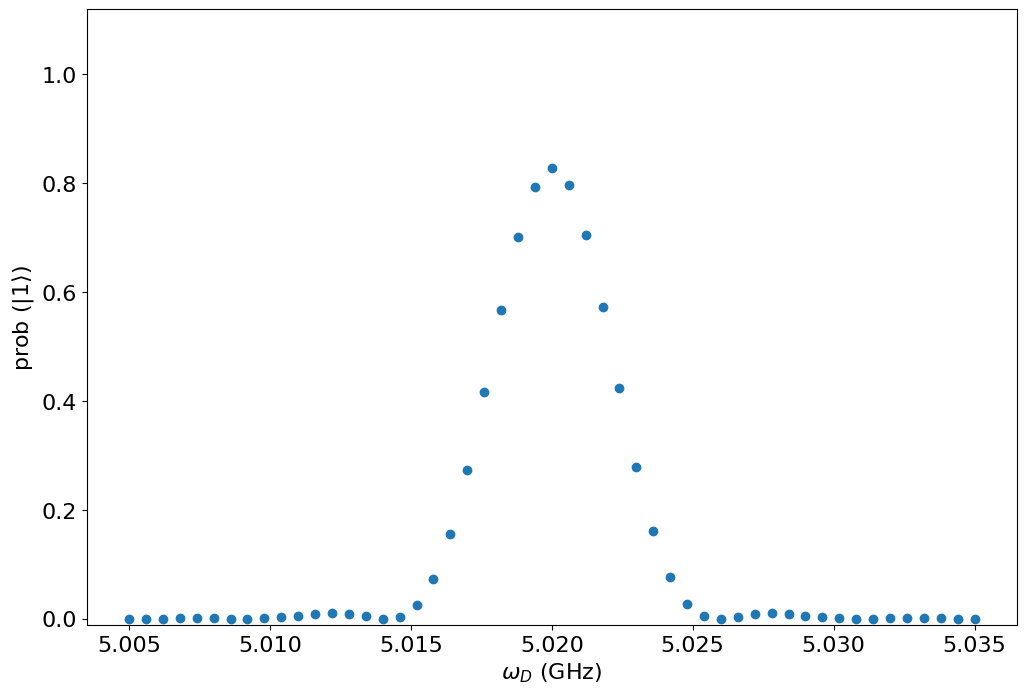

In [8]:
plt.close()
fig, ax = plt.subplots(1,1, figsize = (12,8))
ax.scatter(frequencies/1e9, spec_prob1)

ax.set_ylim(-0.012,1.12)
ax.set_xlabel("$\omega_D$ (GHz)")
ax.set_ylabel(r"prob $(|1\rangle)$")

## Rabi

In [10]:
from qiskit_experiments.library.calibration import RoughXSXAmplitudeCal

rabi = RoughXSXAmplitudeCal(
    qubit, cals, backend=pulse_backend, amplitudes=np.linspace(-0.1, 0.1, 51)
)

In [11]:
%%time
results = pulse_backend.run(rabi.circuits())
rabi_prob1 = np.array([psi.probabilities()[1] for psi in results])

CPU times: user 11.1 s, sys: 15.1 ms, total: 11.1 s
Wall time: 11.1 s


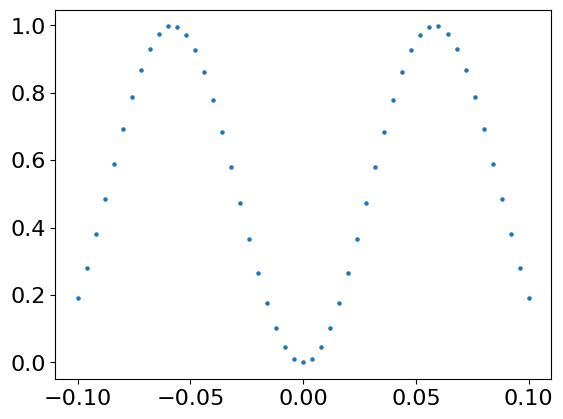

In [12]:
plt.scatter(rabi.experiment_options.get("amplitudes"), rabi_prob1, s=5)